In [2]:
import numpy as np
from scipy.optimize import least_squares
from scipy.integrate import odeint as odeint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [13]:
df = pd.read_csv('elkwolves.txt', sep=' ' )
df.head()

,Year,Elk,Wolves
0,1995,16250,21
1,1996,16250,24
2,1997,13500,32
3,1998,11700,48
4,1999,11750,44


# Problem 1
## Part (b)

In [42]:
def next_state_cont(state, t, theta):
    x, y = state
    a, b, c, d, K = theta
    
    x_prime = (a * x * (1 - (x / K))) - (b * x * y)
    y_prime = (-1 * (c * y)) + (d * x * y)

    next_ = [x_prime, y_prime]
    return next_ 


def gen_modelmap_cont(theta):
    ts = df["Year"].to_numpy()
    initial_state = np.array([df["Elk"][0], df["Wolves"][0]])

    model_map = odeint(next_state_cont, initial_state, ts, args=(theta,))
    model_map = np.array(model_map)

    return model_map

def get_residuals_cont(theta):
    model_map = gen_modelmap_cont(theta)
    resids = model_map - df[["Elk", "Wolves"]].to_numpy()
    resids = resids.flatten()
    return resids

In [43]:
df = df - df.mean()
df = df / df.std()
df = df - df.min() + 0.01

/Users/jakecallahan/opt/anaconda3/envs/580/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """
/Users/jakecallahan/opt/anaconda3/envs/580/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  
/Users/jakecallahan/opt/anaconda3/envs/580/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Optimal parameters
[-9.82243198e-01 -2.17300103e-01  8.33356364e+00  6.95284422e+00
 -2.81361734e+02]


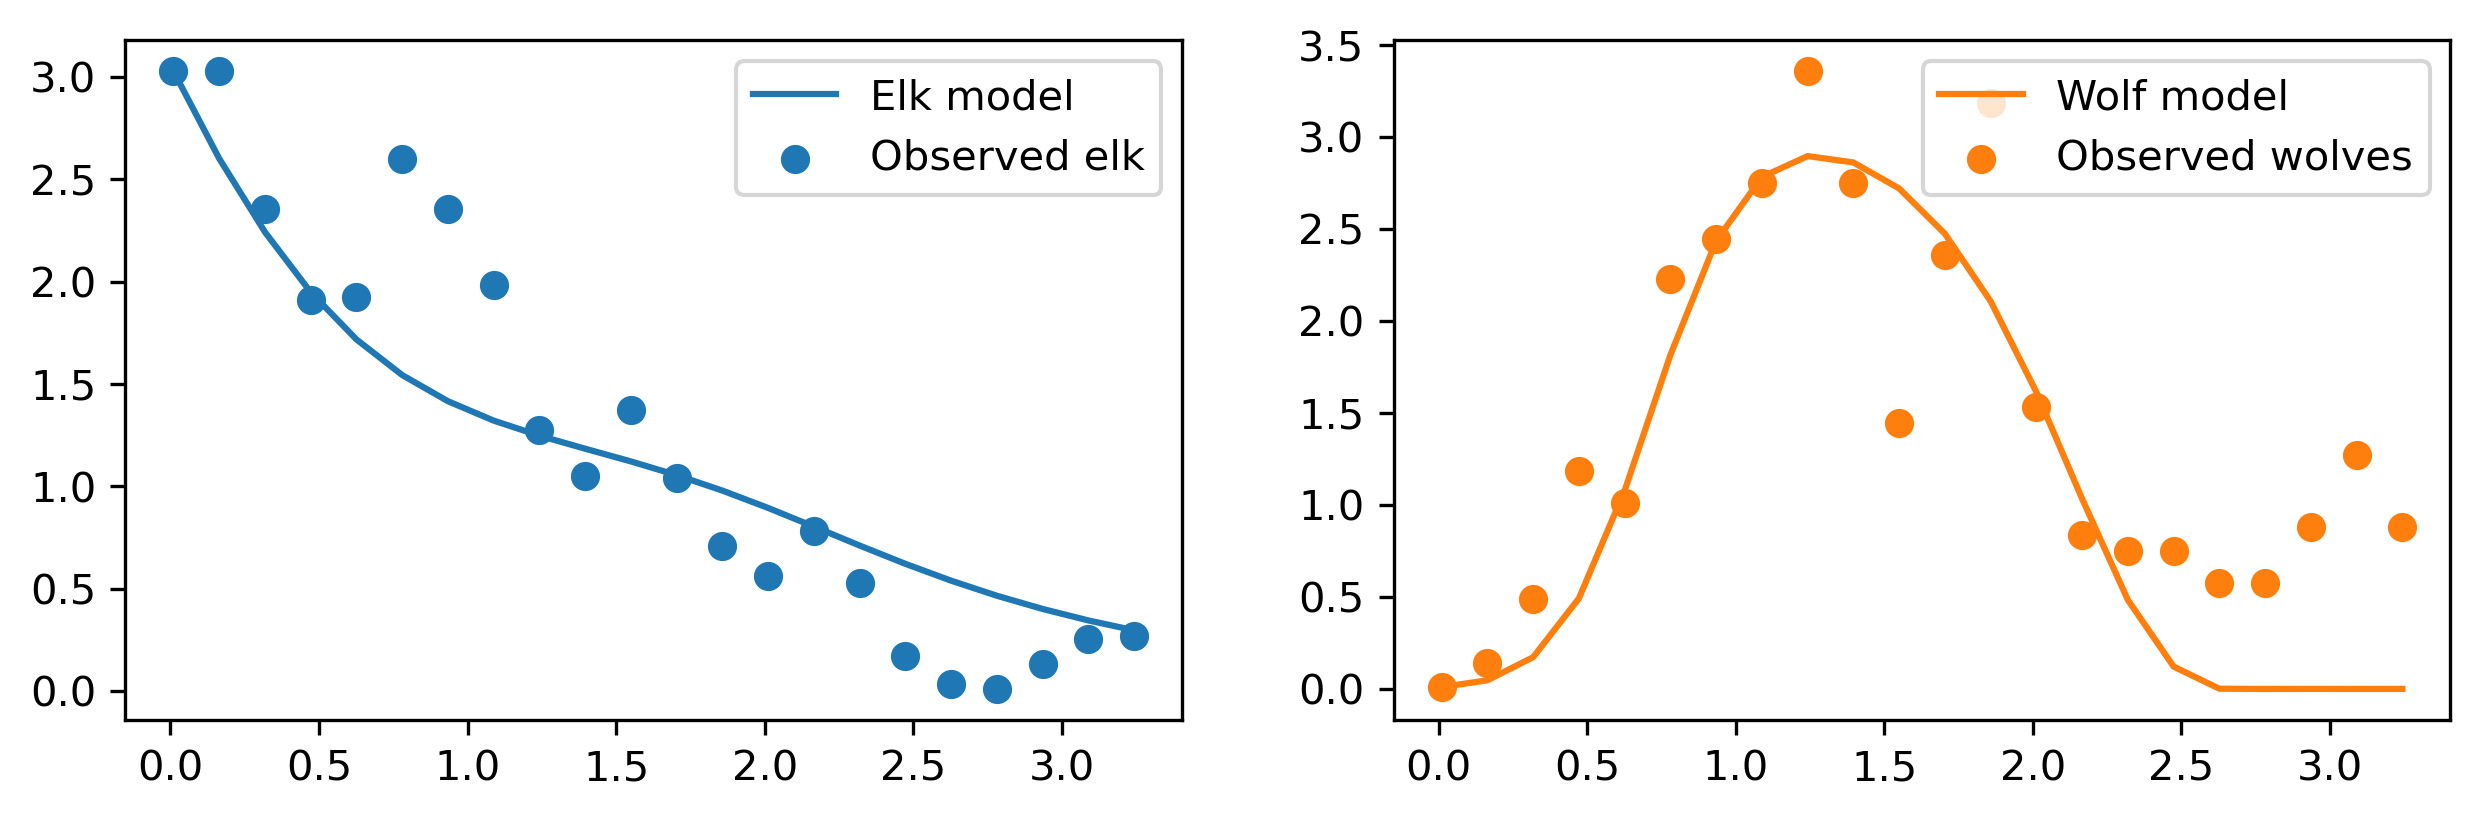

In [94]:
theta_init = np.random.standard_normal(5)
residuals = get_residuals(theta_init)

res = least_squares(get_residuals_cont, theta_init, method="lm")
opt_theta = res["x"]
cost = res["cost"]

model_map_cont = gen_modelmap_cont(opt_theta)

print('Optimal parameters')
print(opt_theta)
fig, axes = plt.subplots(1,2, figsize=(10,3), dpi=300)
axes[0].plot(df["Year"], model_map_cont.T[0], label="Elk model")
axes[0].scatter(df["Year"], df["Elk"], label="Observed elk")
axes[0].legend()

axes[1].plot(df["Year"], model_map.T[1], label="Wolf model",c='tab:orange')
axes[1].scatter(df["Year"], df["Wolves"], label="Observed wolves",c='tab:orange')
axes[1].legend()

plt.show()

## Part (c)

/Users/jakecallahan/opt/anaconda3/envs/580/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """
/Users/jakecallahan/opt/anaconda3/envs/580/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  
/Users/jakecallahan/opt/anaconda3/envs/580/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


Optimal parameters:
[ 1.04519609e+00  3.27403835e-01 -1.64034067e+01 -1.33067651e+01
 -1.67459394e+07]


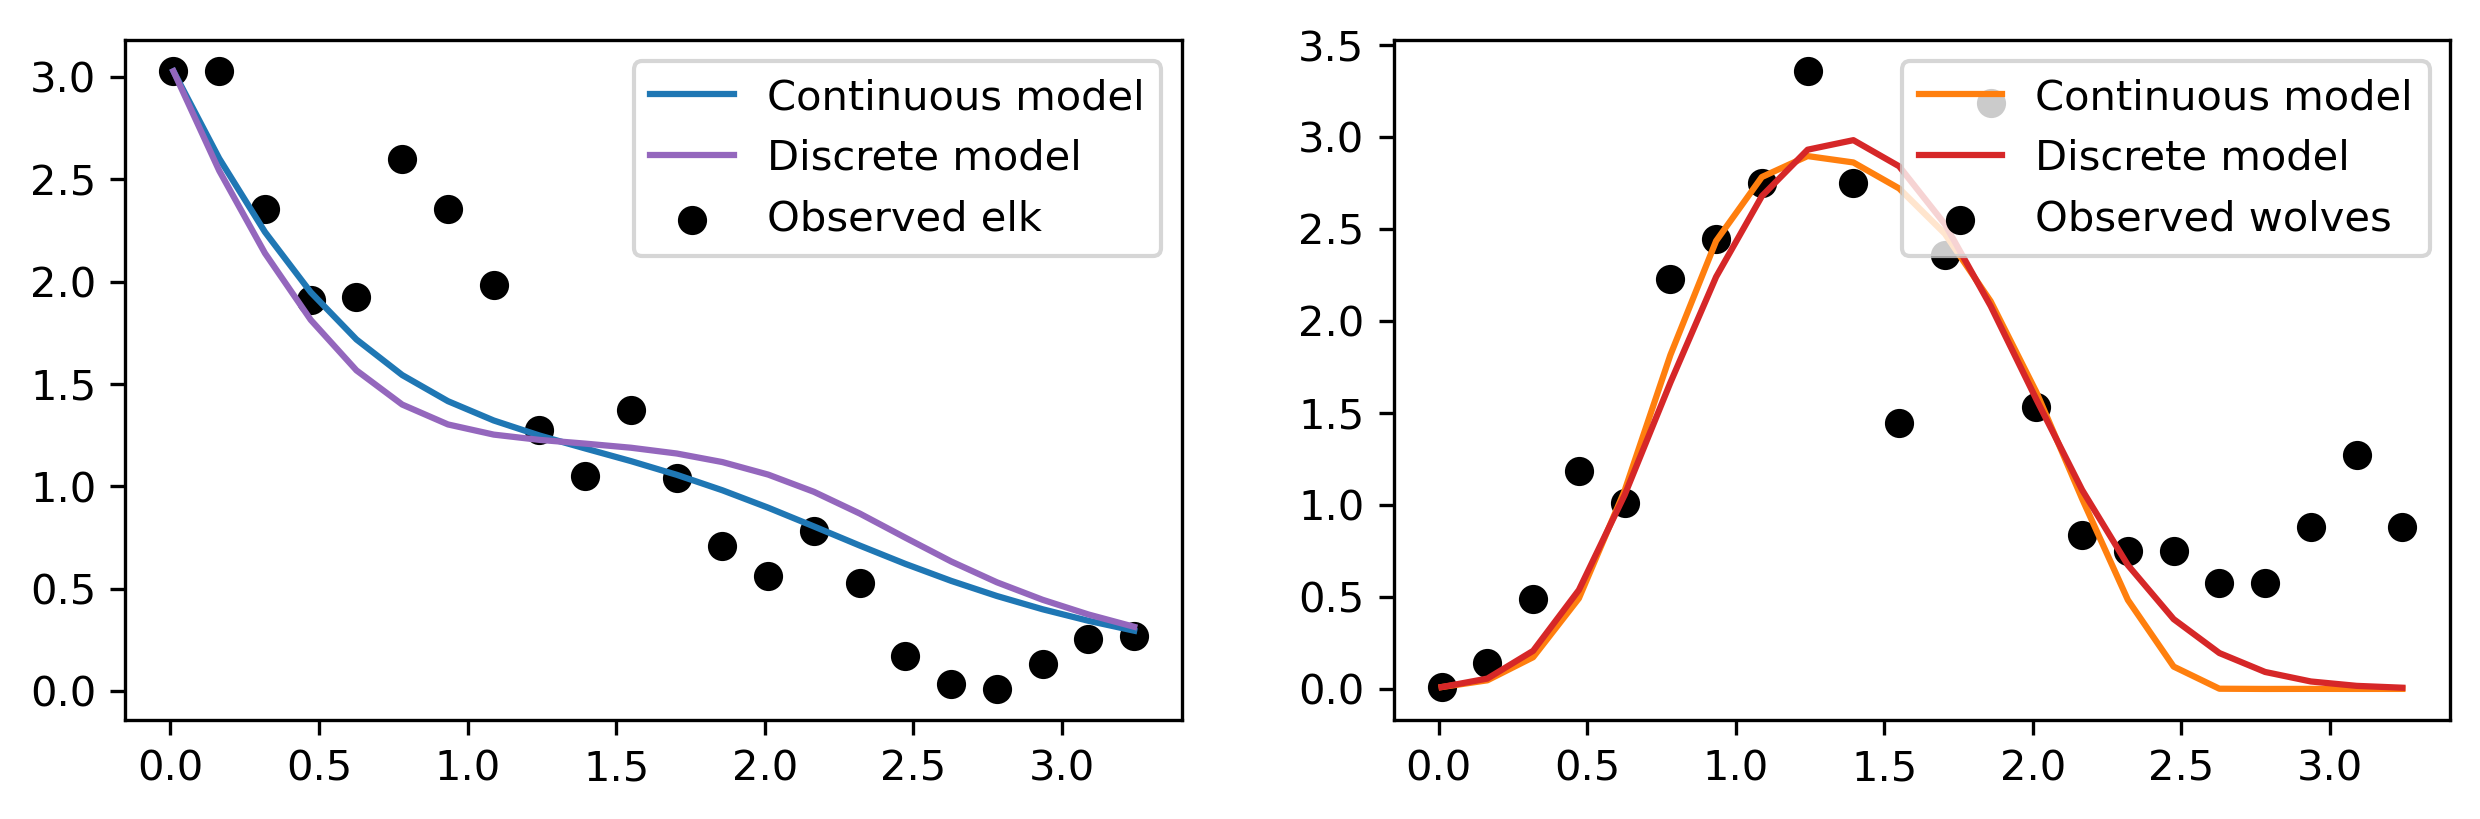

In [93]:
def next_state_disc(state, dt, theta):
    xk, yk = state
    a, b, c, d, K = theta
    
    xk_new = ((1 + (dt * a)) * xk) + (-1 * dt * b * xk * yk) + (-1 * ((dt * a) / K) * xk * xk)
    yk_new = ((1 - (dt * c)) * yk) + (dt * d * xk * yk)

    next_ = [xk_new, yk_new]
    return next_ 


def gen_modelmap_disc(theta):
    ts = df["Year"].to_numpy()
    initial_state = np.array([df["Elk"][0],df["Wolves"][0]])

    model_map = np.empty((ts.shape[0], initial_state.shape[0]))
    model_map[0] = initial_state

    state = initial_state
    
    for i in range(1, ts.shape[0]):
        dt = ts[i - 1] - ts[i]
        state = next_state_disc(state, dt, theta)
        model_map[i] = state

    return model_map

def get_residuals_disc(theta):
    model_map = gen_modelmap_disc(theta)
    residuals = model_map - df[["Elk", "Wolves"]].to_numpy()
    residuals = residuals.flatten()
    return residuals
    

theta_init = np.random.standard_normal(5)
residuals_disc = get_residuals_disc(theta_init)

res_disc = least_squares(get_residuals_disc, theta_init, method="lm")
opt_theta_disc = res_disc["x"]
cost_cont = res_disc["cost"]

model_map_disc = gen_modelmap(opt_theta_disc)

# plt.plot(df["Year"], model_map.T[0], label="pred-elk")
# plt.plot(df["Year"], model_map.T[1], label="pred-wolves")
# plt.scatter(df["Year"], df["Elk"], label="meas-elk")
# plt.scatter(df["Year"], df["Wolves"], label="meas-wolves")
# plt.legend()
# plt.show() 
print('Optimal parameters:')
print(opt_theta_disc)

fig, axes = plt.subplots(1,2, figsize=(10,3), dpi=300)
axes[0].plot(df["Year"], model_map_cont.T[0], label="Continuous model", c='tab:blue')
axes[0].plot(df["Year"], model_map_disc.T[0], label="Discrete model", c='tab:purple')
axes[0].scatter(df["Year"], df["Elk"], label="Observed elk", c='k')
axes[0].legend()

axes[1].plot(df["Year"], model_map_disc.T[1], label="Continuous model",c='tab:orange')
axes[1].plot(df["Year"], model_map_cont.T[1], label="Discrete model", c='tab:red')
axes[1].scatter(df["Year"], df["Wolves"], label="Observed wolves",c='k')
axes[1].legend()

plt.show()

## Part (d)

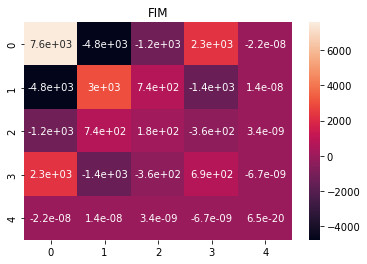

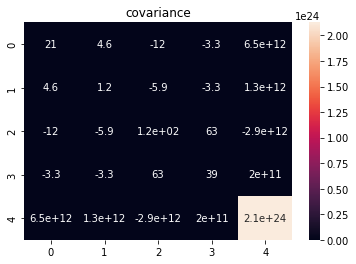

In [86]:
J = res.jac
J @ J.T

sig2 = ((res.cost * 2) / (np.sqrt(len(df["Year"]) - opt_theta.shape[0]))) ** 2
FIM =  J.T @ J * (1 / sig2)
cov = np.linalg.inv(FIM)

sns.heatmap(FIM, annot=True)
plt.title("FIM")
plt.show()
sns.heatmap(cov, annot=True)
plt.title("covariance")
plt.show()

In [87]:
print('Fisher Information Matrix:')
print(FIM)

Fisher Information Matrix:
[[ 7.56509506e+03 -4.76164549e+03 -1.17607634e+03  2.28109825e+03
  -2.20977491e-08]
 [-4.76164549e+03  3.01950189e+03  7.38526422e+02 -1.43099525e+03
   1.38926165e-08]
 [-1.17607634e+03  7.38526422e+02  1.83021628e+02 -3.55079390e+02
   3.43666588e-09]
 [ 2.28109825e+03 -1.43099525e+03 -3.55079390e+02  6.89011214e+02
  -6.66671809e-09]
 [-2.20977491e-08  1.38926165e-08  3.43666588e-09 -6.66671809e-09
   6.45601663e-20]]


In [89]:
print('Parameter uncertainties:')
print(np.diag(cov))

Parameter uncertainties:
[2.10852508e+01 1.21212954e+00 1.24897527e+02 3.85917528e+01
 2.12787983e+24]


# Problem 4
## Part (c)

In [8]:
m = 0.25
mu = 0.5
g_k = 10
A = np.array([[m, m], 
              [mu * (m - 1), mu * m]])

inv = np.linalg.inv(A - np.eye(A.shape[0]))
B = np.array([[m], [mu * m]])
u = np.array([g_k])
x_k = -1 * inv @ B @ u
c_k, i_k = x_k
y_k = c_k + i_k + g_k
print(f'C(k) = {c_k}, Y(k) = {y_k}, I(k) = {i_k}')

C(k) = 3.333333333333334, Y(k) = 13.333333333333334, I(k) = 0.0


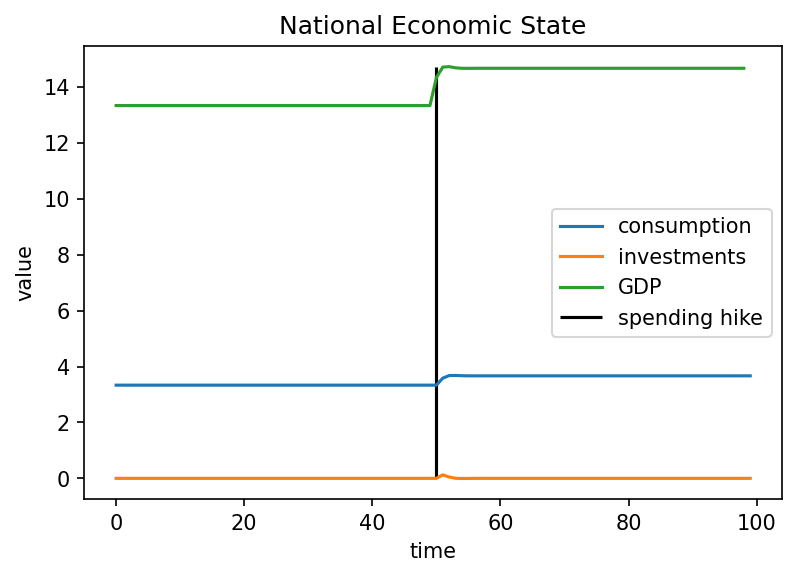

In [17]:
def get_x(A, B, x, u):
    return (A @ x) + (B @ u)

def get_y(C, D, x, u):
    return (C @ x) + (D @ u)

ts = 100
x0 = np.array(x_k) # initial equilibrium is C_k = 0, I_k = 0
C = np.array([[1, 1]])
D = np.array([[1]])
us = np.expand_dims(np.ones((numTimeSteps,)), axis=1) * 10

xs = np.empty((ts, x0.shape[0]))
ys = np.empty((ts - 1,))
xs[0] = x0

hiked = False
for t in range(0, ts - 1):

    if t >= (ts / 2) and not hiked:
        hike_time = t
        us = us + (0.1 * us)
        hiked = True

    x = getXnext(A, B, xs[t], us[t])
    xs[t + 1] = x
    y = getY(C, D, xs[t], us[t])
    ys[t] = y


plt.figure(dpi=150)
for index, x in enumerate(xs.T):
    if index == 0:
        label="consumption"
    elif index == 1:
        label="investments" 
    plt.plot(x, label=label)


plt.plot(ys, label="GDP")
plt.vlines(hike_time, ymin=0, ymax=np.max(ys), label="spending hike")
plt.ylabel("value")
plt.xlabel("time")
plt.title("National Economic State")
plt.legend()
plt.show()